# Distributions from estimated HOLE conductances

Requires: 
* `seaborn==0.12.2`
* `pandas==1.5.2`

Input data:
* `data/mutants_docking_pdbnames_labelled.json`
* `data/{mutant}_hole_1-1000.raw_dat`

In [2]:
import os
import sys
import numpy as np
import json
import subprocess
import operator
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
mutant_names = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

In [4]:
path = 'data/mutants_docking_pdbnames_labelled.json'
with open(path, 'r') as fp:
    mutants_docking_pdbnames_labelled = json.load(fp)

HOLE failed for cWza: model number 0112
HOLE failed for cWza: model number 0243
HOLE failed for cWza: model number 0800


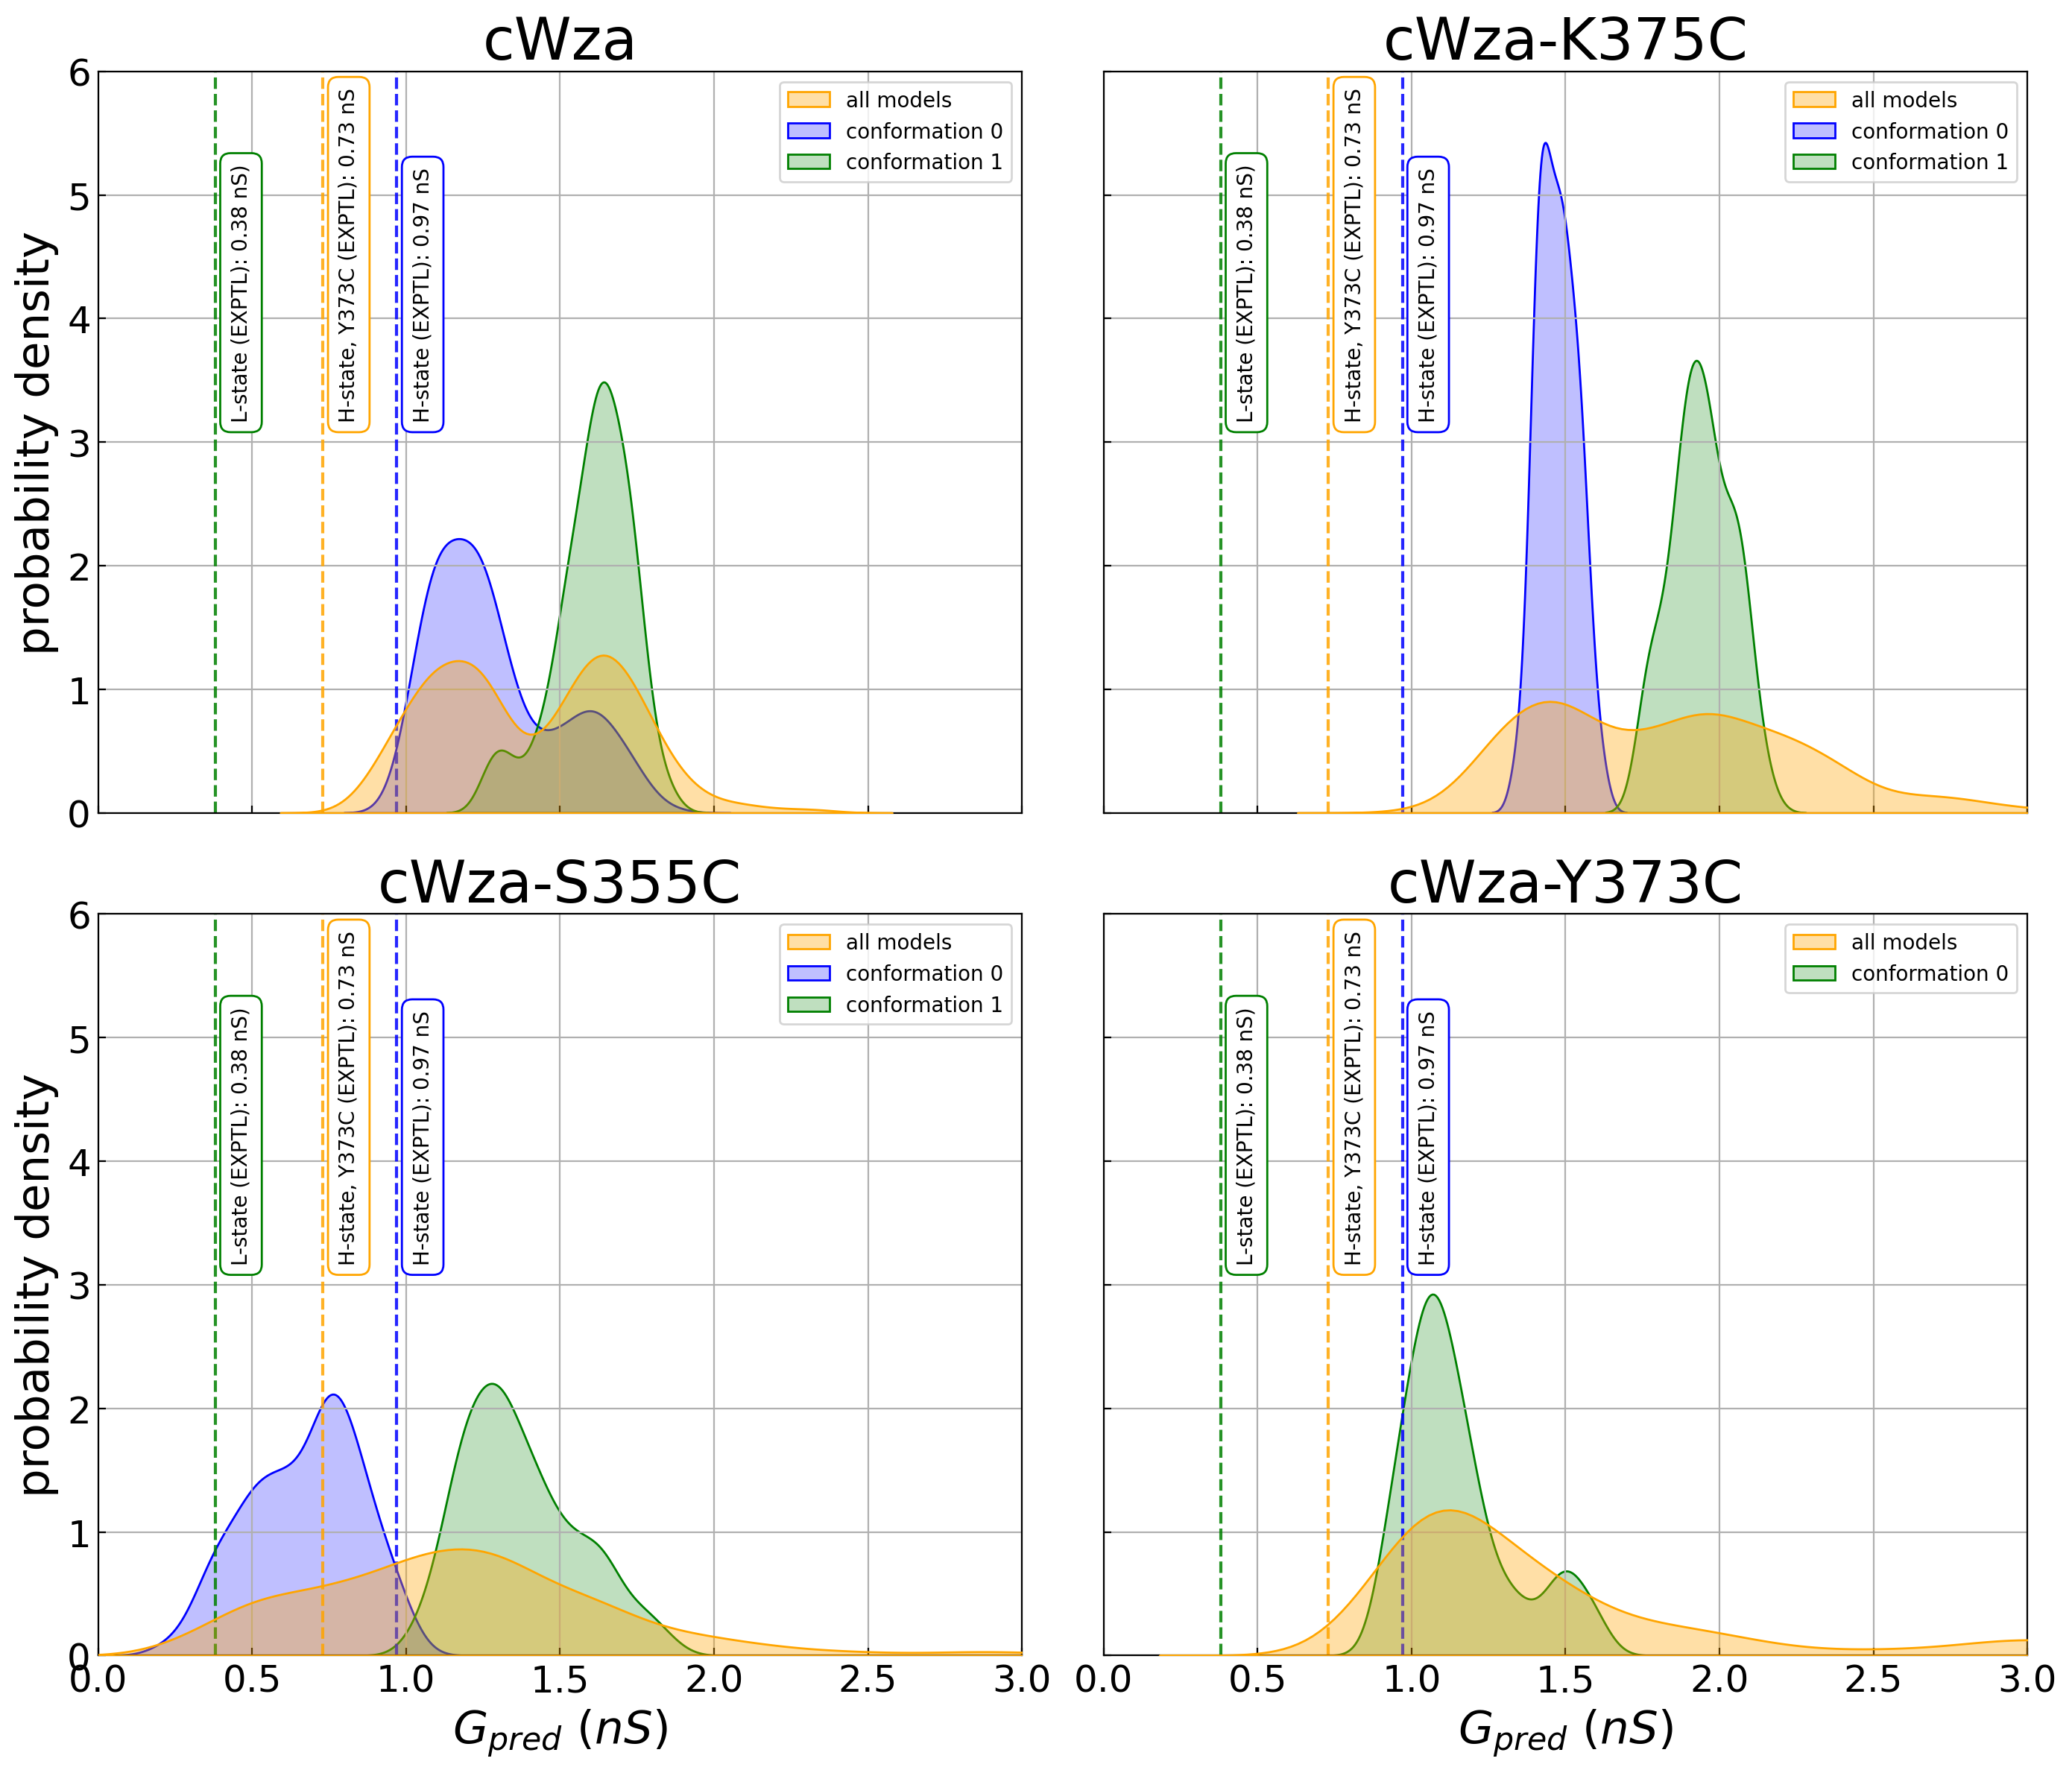

In [9]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=200, sharex=True,sharey=True)

Axes = {
    'cWza': ax[0][0],
    'cWza-K375C': ax[0][1],
    'cWza-S355C': ax[1][0],
    'cWza-Y373C': ax[1][1]
}

labels = {
    'cWza':("","probability density"),
    'cWza-K375C':("",""),
    'cWza-S355C':("$G_{pred}$ ($nS$)","probability density"),
    'cWza-Y373C':("$G_{pred}$ ($nS$)","")
}

Conformations = {
    'cWza': [0, 1],
    'cWza-K375C': [0, 1],
    'cWza-S355C': [0, 1],
    'cWza-Y373C': [0]    
}

Colors = {0:"blue", 1:'green'}

for mutant in mutant_names:
    ax = Axes[mutant]
    
    # filter HOLE data per mutant
    filename = f'data/{mutant}_hole_1-1000.raw_dat'
    lines = [l.split(' (TAG') for l in open(filename,'r').readlines()]
    Gpred_data = {}
    for l in lines:
        try:
            model_number, data_raw = l
            Gpred  = 0.001*float(data_raw.split("Gpred=")[-1].strip().split()[0])
            Gpred_data[model_number] = Gpred
        except Exception as e:
            print(f"HOLE failed for {mutant}: model number {l[0].strip()}")
    
    # plot background histogram - all models
    dataset = list(Gpred_data.values())
    sns.kdeplot(dataset,fill=True,label='all models',color='orange',alpha=0.35,ax=ax,zorder=10)
    
    # filter data for PDBs within HPRs
    for g in Conformations[mutant]:
        model_numbers = [pdbname.split('_')[3] for pdbname in mutants_docking_pdbnames_labelled[mutant][str(g)]]
        
        models_labelled_Gpred  = []
        for x in model_numbers:
            try:
                models_labelled_Gpred.append(Gpred_data[x])
            except: KeyError
        
        if mutant == 'cWza-Y373C':
            c = 'green'
        else:
            c = Colors[g]
        
        # plot histogram for models from the HPR (pore conformation)
        dataset = models_labelled_Gpred
        sns.kdeplot(dataset,fill=True,label='conformation '+str(g),color=c,alpha=0.25,ax=ax,zorder=-10)
    
    # L-state (EXPTL)
    Gpred_cWza_Lstate = [0.38]
    ax.plot(2*Gpred_cWza_Lstate,(0,6),lw=1.5,linestyle='--',color='green',alpha=0.85)
    ax.text(0.43,3.2,'L-state (EXPTL): 0.38 nS)',rotation=90,fontsize=10,
            bbox=dict(facecolor='white', edgecolor='green', boxstyle='round, pad=0.5'))
    
    # H-state, Y373C (EXPTL)
    Gpred_cWza_Hstate = [0.73]
    ax.plot(2*Gpred_cWza_Hstate,(0,6),lw=1.5,linestyle='--',color='orange',alpha=0.85)
    ax.text(0.78,3.2,'H-state, Y373C (EXPTL): 0.73 nS',rotation=90,fontsize=10,
            bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round, pad=0.5'))
    
    # H-state (EXPTL)
    Gpred_cWza_Hstate = [0.97]
    ax.plot(2*Gpred_cWza_Hstate,(0,6),lw=1.5,linestyle='--',color='blue',alpha=0.85)
    ax.text(1.02,3.2,'H-state (EXPTL): 0.97 nS',rotation=90,fontsize=10,
            bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round, pad=0.5'))
    
    # customise plot
    ax.set_title(mutant, fontsize=28)
    ax.tick_params(axis='both',direction='in',labelsize=18)
    l1,l2 = labels[mutant]
    ax.set_xlabel(l1,fontsize=22)
    ax.set_ylabel(l2,fontsize=22)
    ax.legend(loc='best')
    ax.set_xlim(0,3)
    ax.set_ylim(0,6)
    ax.grid(True)

fig.tight_layout()
plt.show()